# 策略梯度算法

In [1]:
import gymnasium as gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import rl_utils

定义策略网络 **PolicyNet**，其输入是某个状态，输出则是该状态下的动作概率分布

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)



In [3]:
class REINFORCE:
    def __init__(self, state_dim, hidden_dim, action_dim, 
                learning_rate, gamma, device):
        self.policy_net = PolicyNet(state_dim = state_dim, hidden_dim= hidden_dim, action_dim=action_dim).to(device)

        # optimizer should use learning_rate
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=learning_rate)

        self.gamma = gamma
        self.device = device

    def take_action(self, state):
        state = torch.tensor([np.array(state)], dtype=torch.float).to(self.device)
        probs = self.policy_net(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()
    
    def update(self, transition_dict):
        reward_list = np.array(transition_dict['rewards'])
        state_list = np.array(transition_dict['states'])
        action_list = np.array(transition_dict['actions'])
        

        G = 0
        self.optimizer.zero_grad()
        for i in reversed(range(len(reward_list))):
            reward = reward_list[i]
            state = torch.tensor([state_list[i]], dtype=torch.float).to(self.device)
            # ensure action tensor is long for gather
            action = torch.tensor([action_list[i]]).view(-1, 1).to(self.device)

            log_prob = torch.log(self.policy_net(state).gather(1, action))
            G = self.gamma * G + reward
            loss = -G * log_prob
            loss.backward()
        self.optimizer.step()

In [4]:
learning_rate = 1e-3
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')

env_name = "CartPole-v1"
env = gym.make(env_name)
# env.reset(seed=0)
# torch.manual_seed(0)
state_dim = env.observation_space.shape[0] # type: ignore
action_dim = env.action_space.n     # type:ignore
agent = REINFORCE(state_dim, hidden_dim, action_dim, learning_rate, gamma, device)

return_list = []

for i in range(10):
    with tqdm(total = num_episodes / 10, desc=f"Iteration: {i}") as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            transition_dict = {
                'states': [],
                'rewards': [],
                'actions':[],
            }
            
            done = False
            # unpack env.reset() -> (state, info)
            state, _ = env.reset()
            while not done:
                action = agent.take_action(state)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                transition_dict['states'].append(state)
                transition_dict['rewards'].append(reward)
                transition_dict['actions'].append(action)
                state = next_state
                episode_return += reward # type: ignore

            return_list.append(episode_return)
            agent.update(transition_dict)
            
            if (i_episode+1) % 10 == 0:
                pbar.set_postfix({
                    'episode': num_episodes / 10 * i + i_episode + 1,
                    'return': "{:.3f}".format(np.mean(return_list[-10:]))
                })
            pbar.update(1)

Iteration: 0:   0%|          | 0/100.0 [00:00<?, ?it/s]/var/folders/mm/1cxc88791zqf8gynh3j4qjr40000gn/T/ipykernel_10352/4123545934.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  state = torch.tensor([np.array(state)], dtype=torch.float).to(self.device)
/var/folders/mm/1cxc88791zqf8gynh3j4qjr40000gn/T/ipykernel_10352/4123545934.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  state = torch.tensor([np.array(state)], dtype=torch.float).to(self.device)
Iteration: 0: 100%|██████████

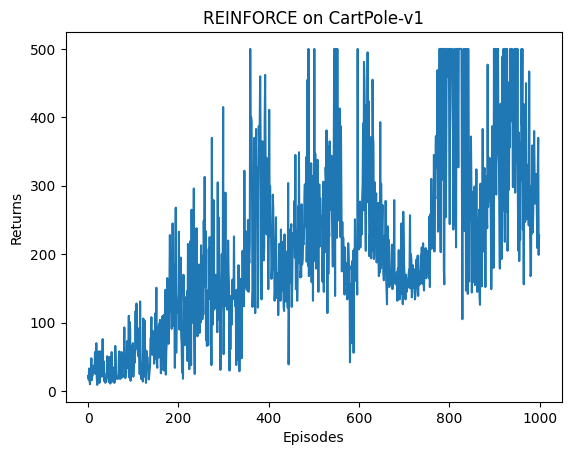

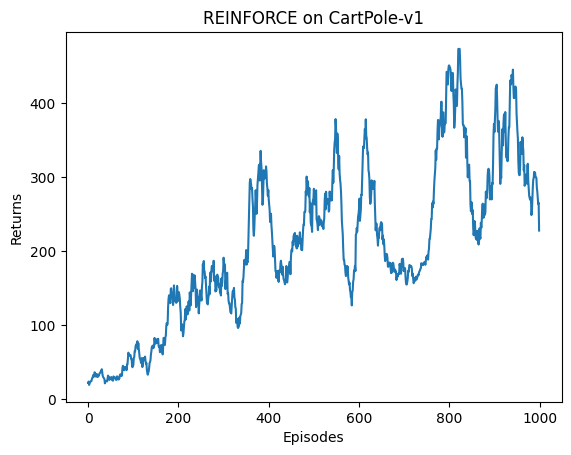

In [5]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()